## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [2]:
data_path = 'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,SPRING,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,SPRING,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


## EDA

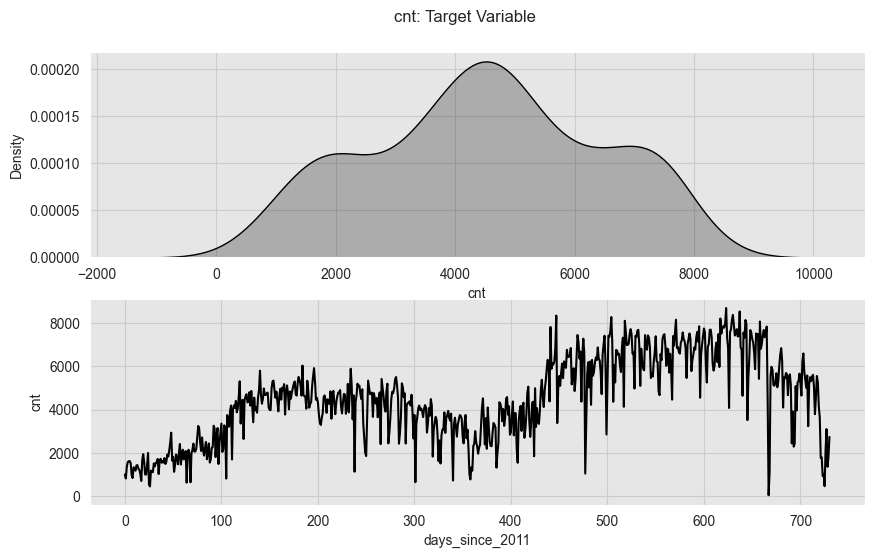

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1)
sns.kdeplot(x='cnt', data=raw_data_df, fill=True, color='black', ax=ax[0])
sns.lineplot(x='days_since_2011', y='cnt', data=raw_data_df, color='black', ax=ax[1])
fig.suptitle('cnt: Target Variable', y=0.95);

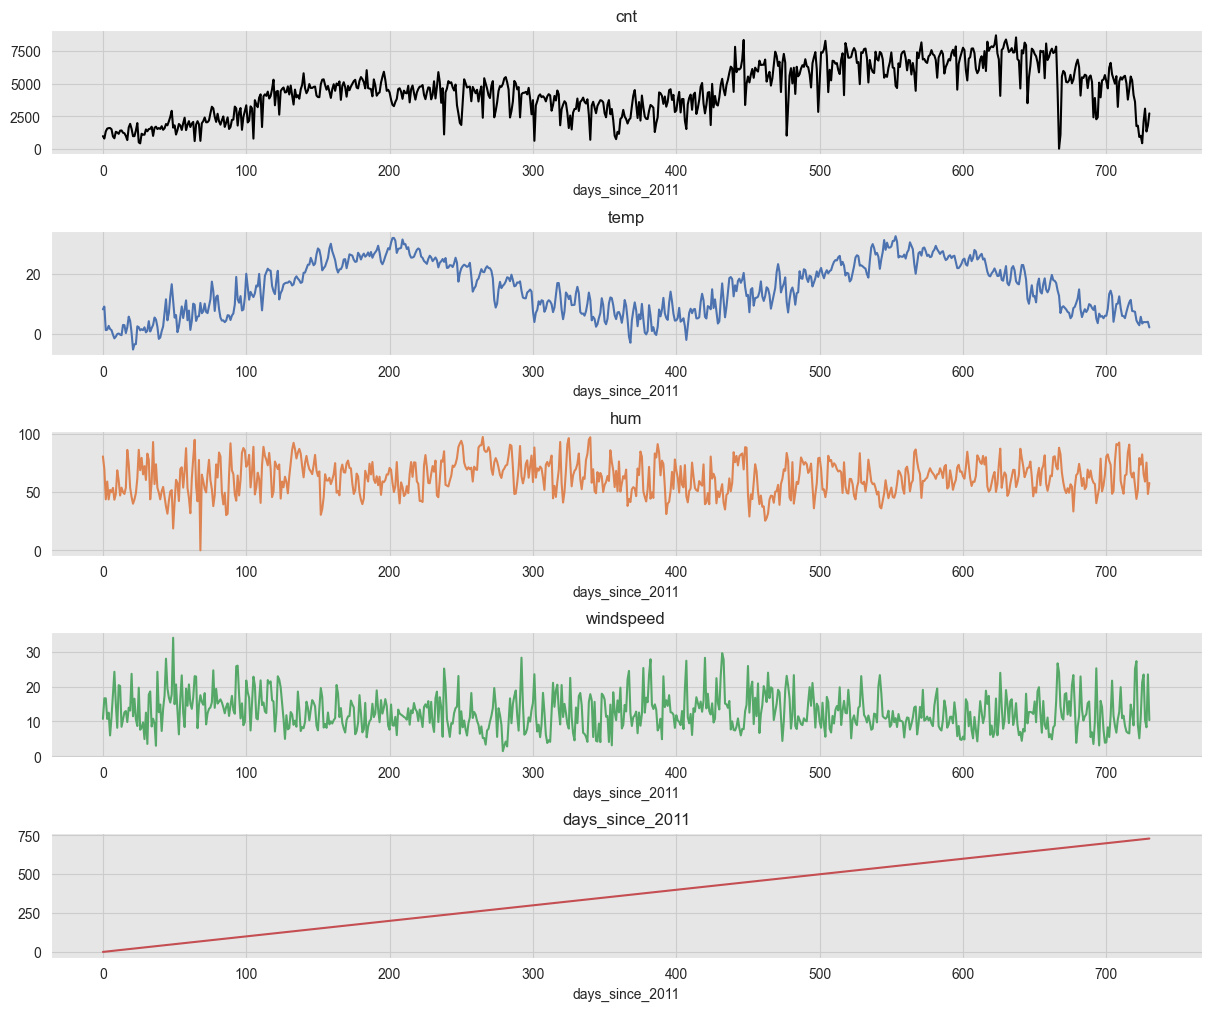

In [5]:
numeric_features = [
    'temp',
    'hum',
    'windspeed',
    'days_since_2011',
]

target = 'cnt'

fig, axes = plt.subplots(
    nrows=len(numeric_features) + 1,
    ncols=1,
    figsize=(12, 10),
    constrained_layout=True
)

sns.lineplot(
        x='days_since_2011',
        y=target,
        data=raw_data_df,
        color='black',
        ax=axes[0]
    )
axes[0].set(title=target, ylabel=None)

for i, feature in enumerate(numeric_features):
    ax = axes[i + 1]
    sns.lineplot(
        x='days_since_2011',
        y=feature,
        data=raw_data_df,
        color=sns_c[i],
        ax=ax
    )
    ax.set(title=feature, ylabel=None)

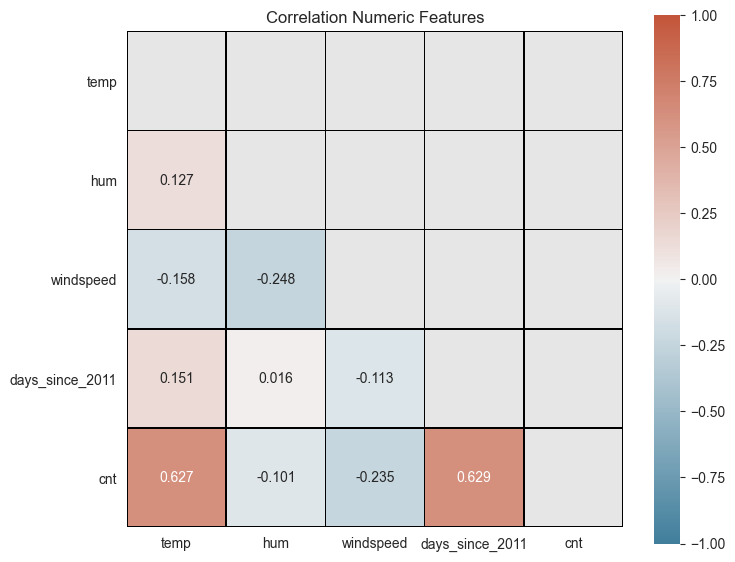

In [6]:
corr_df = raw_data_df[numeric_features + [target]].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set(title='Correlation Numeric Features');

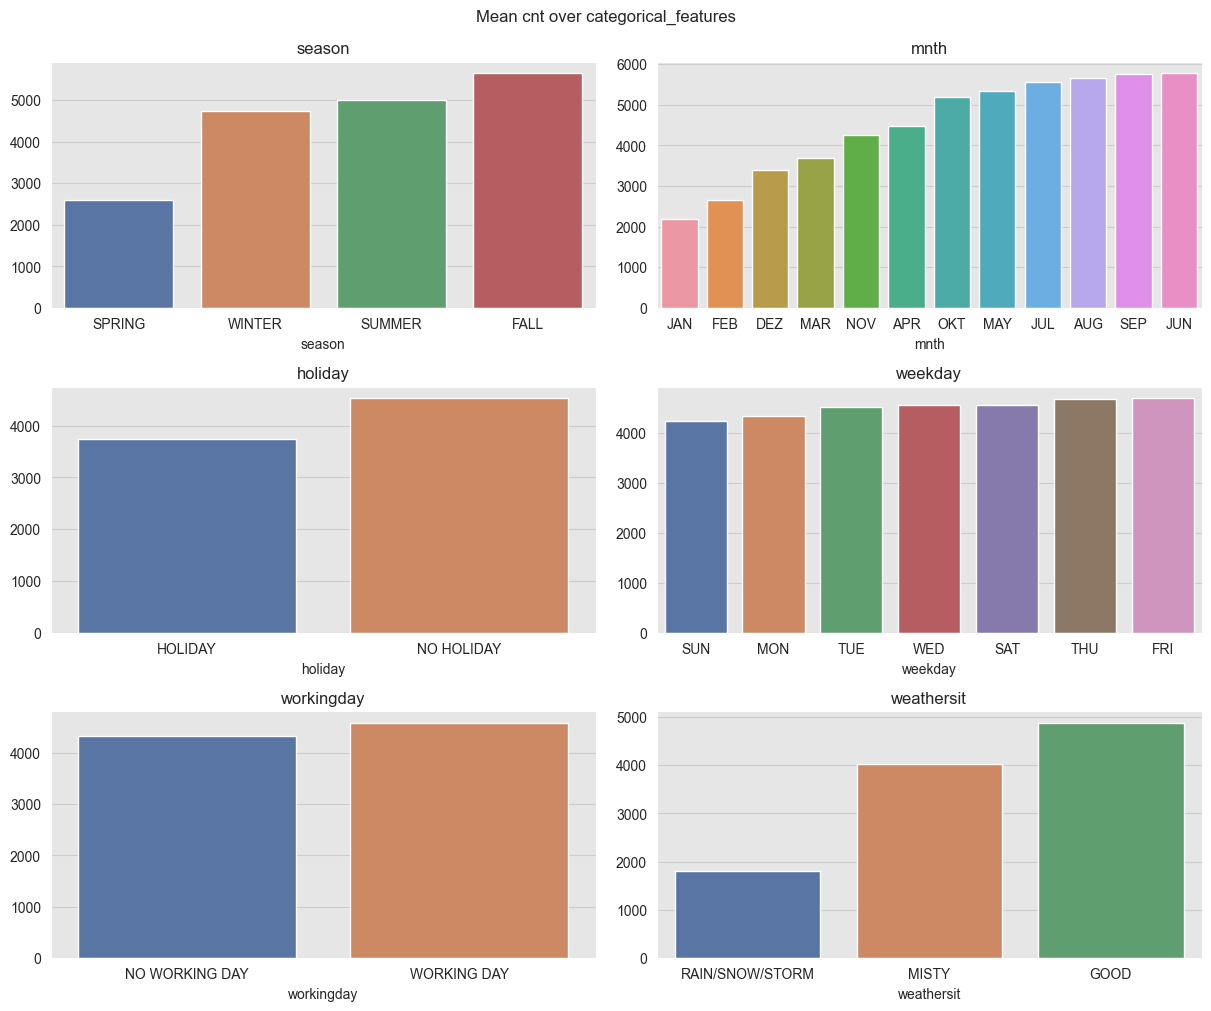

In [7]:
categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
]

fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 10),
    constrained_layout=True
)

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    ax = axes[i]

    feature_df = raw_data_df \
        .groupby(feature, as_index=False) \
        .agg({target: np.mean}) \
        .sort_values(target)

    sns.barplot(
        x=feature,
        y=target,
        data=feature_df,
        dodge=False,
        ax=ax
    )
    ax.set(title=feature, ylabel=None)

fig.suptitle(f'Mean {target} over categorical_features');

## Train - Test Split

In [8]:
from sklearn.model_selection import train_test_split

x = raw_data_df.copy().drop([target, 'yr'], axis=1)
y = raw_data_df.copy()[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, shuffle=False
)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoLars, ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

categorical_features = [
    'season',
    'mnth',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
]

numeric_features = [
    'temp',
    'hum',
    'windspeed',
    'days_since_2011',
]

features =  numeric_features + categorical_features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder())
])

In [10]:
features_ext = numeric_features \
    + list(
        categorical_transformer['one_hot'] \
        .fit(x_train[categorical_features]) \
        .get_feature_names(categorical_features)
    )

print(f'Number of features after pre-processing: {len(features_ext)}')

Number of features after pre-processing: 34


### Linear Model

In [11]:
linear_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

linear_feature_engineering = Pipeline(steps=[
    ('linear_preprocessor', linear_preprocessor),
    ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('variance_threshold', VarianceThreshold()),
    #('pca', PCA())
])

linear_pipeline = Pipeline(steps=[
    ('linear_feature_engineering', linear_feature_engineering),
    ('linear_regressor', Lasso(fit_intercept=False, normalize=False, max_iter=2500))
])

linear_param_grid = {
    'linear_regressor__alpha': np.logspace(start=-3, stop=2, num=10),
    #'linear_regressor__l1_ratio': np.linspace(start=0, stop=1, num=10)
}

cv = TimeSeriesSplit(n_splits=5, test_size=(7 * 3), gap=0)

linear_grid_search = GridSearchCV(
    estimator=linear_pipeline,
    param_grid=linear_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

In [12]:
linear_grid_search = linear_grid_search.fit(X=x_train, y=y_train)

/opt/anaconda3/envs/self-dev/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13850966.70027981, tolerance: 609938.3091000001
  max_iter, tol, rng, random, positive)
/opt/anaconda3/envs/self-dev/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20353566.18125925, tolerance: 687849.6017
  max_iter, tol, rng, random, positive)
/opt/anaconda3/envs/self-dev/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22898062.12921551, tolerance: 759276.1901
  max_iter, tol, rng, random, positive)
/opt/anaconda3/envs/self-dev/lib/python3.6/site-packages/sklearn/linear_model/_coordinat

In [13]:
tree_preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

tree_feature_engineering = Pipeline(steps=[
    ('tree_preprocessor', tree_preprocessor)
])

tree_pipeline = Pipeline(steps=[
    ('tree_feature_engineering', tree_feature_engineering),
    ('tree_regressor',  XGBRegressor())
])

tree_param_grid = {
    'tree_regressor__learning_rate': [0.01, 0.05, 0.075, 0.1, 0.2],
    'tree_regressor__max_depth': [3, 5, 8, 13]
}

tree_grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=tree_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv
)

In [14]:
tree_grid_search = tree_grid_search.fit(X=x_train, y=y_train)

## Model Performance

In [15]:
y_train_pred_linear = linear_grid_search.predict(X=x_train)
y_test_pred_linear = linear_grid_search.predict(X=x_test)

y_train_pred_tree = tree_grid_search.predict(X=x_train)
y_test_pred_tree = tree_grid_search.predict(X=x_test)

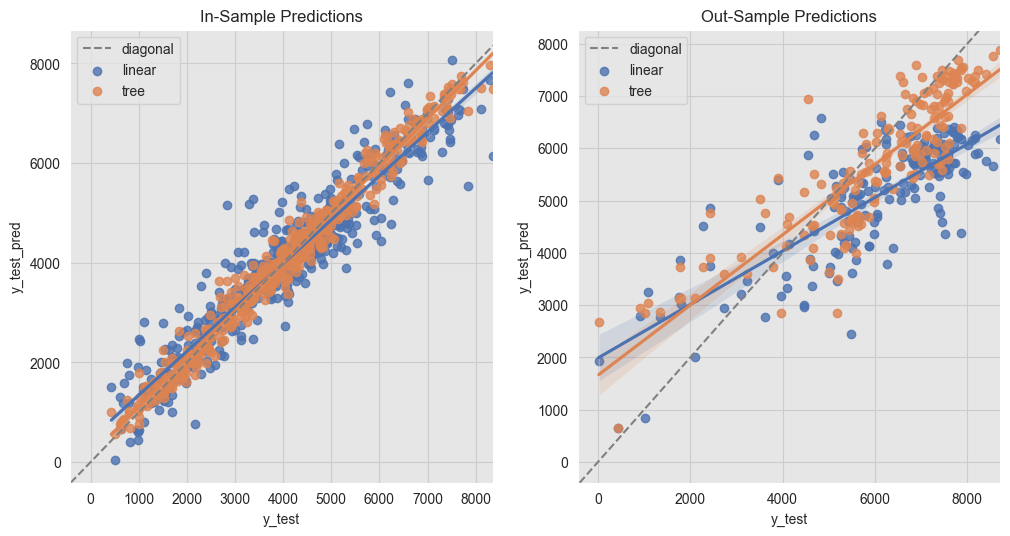

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.regplot(x=y_train, y=y_train_pred_linear, color=sns_c[0], label='linear', ax=ax[0])
sns.regplot(x=y_train, y=y_train_pred_tree, color=sns_c[1], label='tree', ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend()
ax[0].set(title='In-Sample Predictions', xlabel='y_test', ylabel='y_test_pred');

sns.regplot(x=y_test, y=y_test_pred_linear, color=sns_c[0], label='linear', ax=ax[1])
sns.regplot(x=y_test, y=y_test_pred_tree, color=sns_c[1], label='tree', ax=ax[1])
ax[1].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[1].legend()
ax[1].set(title='Out-Sample Predictions', xlabel='y_test', ylabel='y_test_pred');

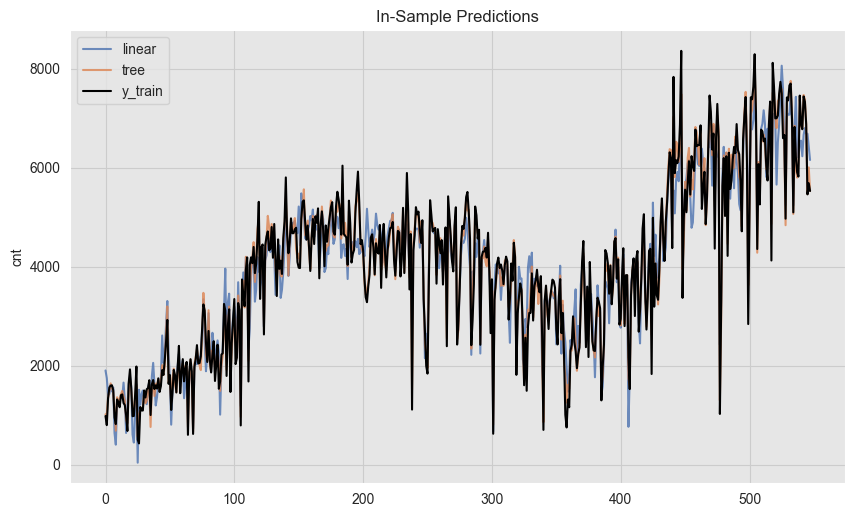

In [17]:
fig, ax = plt.subplots()

sns.lineplot(
    x=range(y_train_pred_linear.shape[0]),
    y=y_train_pred_linear,
    color=sns_c[0],
    label='linear',
    alpha=0.8,
    ax=ax
)

sns.lineplot(
    x=range(y_train_pred_linear.shape[0]),
    y=y_train_pred_tree,
    color=sns_c[1],
    label='tree',
    alpha=0.8,
    ax=ax
)

sns.lineplot(
    x=range(y_train.shape[0]),
    y=y_train,
    color='black',
    label='y_train',
    ax=ax
)

ax.set(title='In-Sample Predictions');

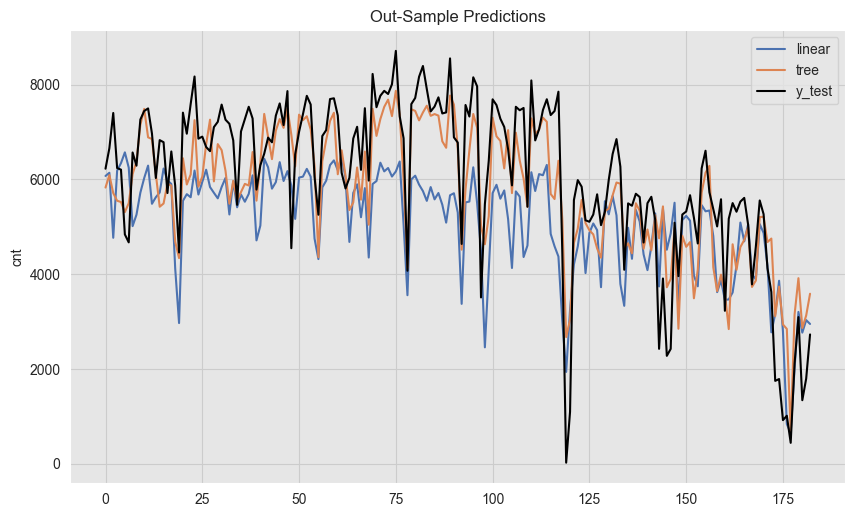

In [18]:
fig, ax = plt.subplots()

sns.lineplot(
    x=range(y_test_pred_linear.shape[0]),
    y=y_test_pred_linear,
    color=sns_c[0],
    label='linear',
    ax=ax
)

sns.lineplot(
    x=range(y_test_pred_linear.shape[0]),
    y=y_test_pred_tree,
    color=sns_c[1],
    label='tree',
    ax=ax
)

sns.lineplot(
    x=range(y_test.shape[0]),
    y=y_test,
    color='black',
    label='y_test',
    ax=ax
)

ax.set(title='Out-Sample Predictions');

---
## Feature Importance

### Model Specific

- Linear Model

In [19]:
from itertools import compress

polynomial_features = linear_grid_search.best_estimator_['linear_feature_engineering']['polynomial'].get_feature_names(features_ext)
variance_threshold_support = linear_grid_search.best_estimator_['linear_feature_engineering']['variance_threshold'].get_support()

variance_threshold_support

linear_model_coef_df = pd.DataFrame(data={
    'linear_features' : compress(polynomial_features, variance_threshold_support),
    'coef_': linear_grid_search.best_estimator_['linear_regressor'].coef_
})

linear_model_coef_df = linear_model_coef_df \
    .assign(abs_coef_ = lambda x: x['coef_'].abs()) \
    .sort_values('abs_coef_', ascending=False) \
    .reset_index(drop=True)

linear_model_coef_df.head(15)

,linear_features,coef_,abs_coef_
0,holiday_NO HOLIDAY,2351.152978,2351.152978
1,weathersit_GOOD,1722.696368,1722.696368
2,weathersit_MISTY,1408.776051,1408.776051
3,holiday_HOLIDAY,1175.566367,1175.566367
4,season_SPRING mnth_DEZ,-735.630896,735.630896
5,temp,576.626938,576.626938
6,days_since_2011 season_SUMMER,443.351353,443.351353
7,temp season_SPRING,360.987214,360.987214
8,season_FALL,359.349426,359.349426
9,season_SUMMER,356.825497,356.825497


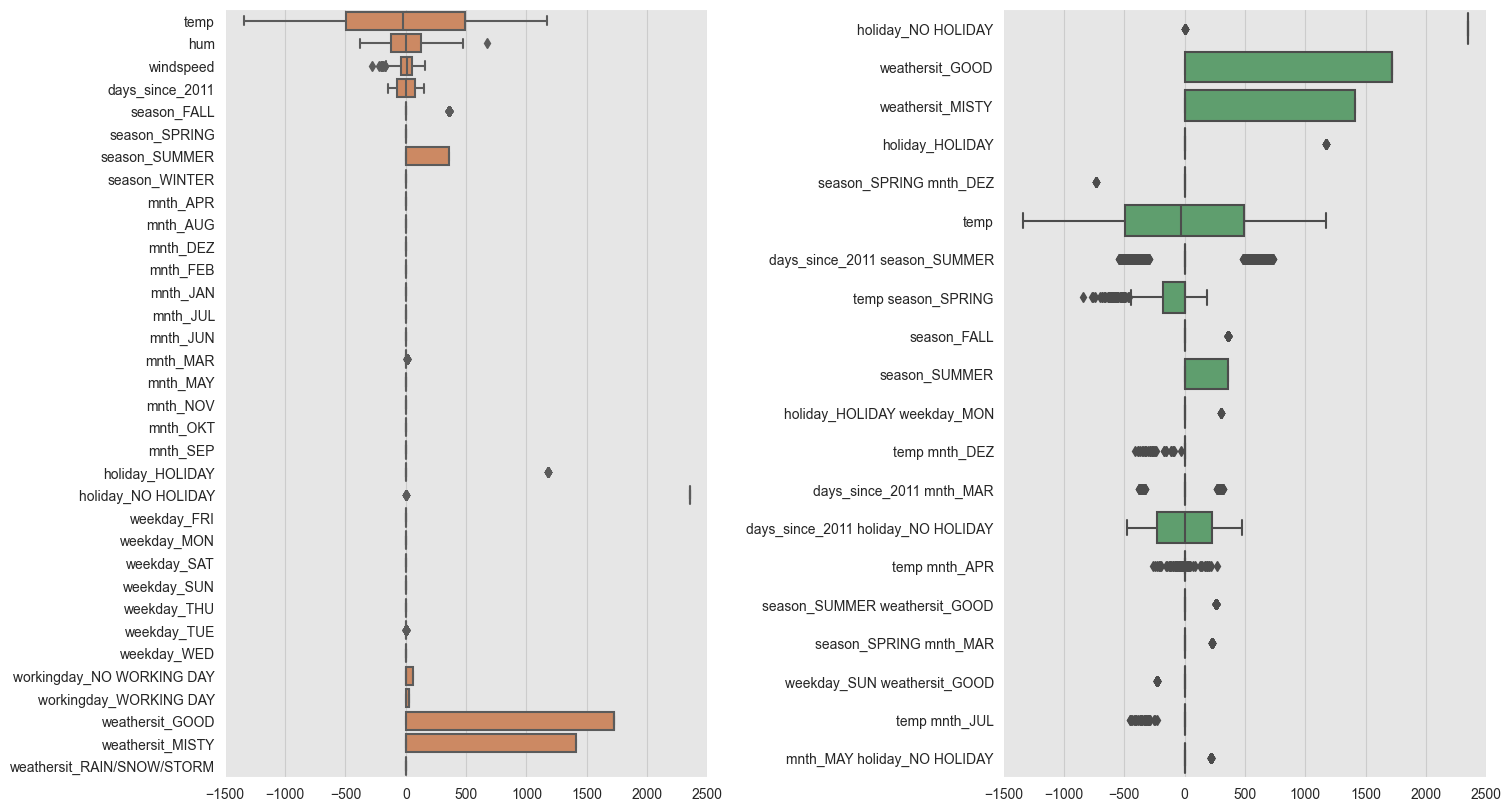

In [20]:
linear_model_effects = np.multiply(
    linear_grid_search.best_estimator_['linear_regressor'].coef_,
    linear_grid_search.best_estimator_['linear_feature_engineering'].transform(x_train).todense()
)

linear_model_effects_df = pd.DataFrame(
    data=linear_model_effects,
    columns=compress(polynomial_features, variance_threshold_support)
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True) 

sns.boxplot(
    data=linear_model_effects_df.iloc[:, range(len(features_ext))],
    orient='h',
    color=sns_c[1],
    ax=ax[0]
)
ax[0].set(xlim=(-1500, 2500))

sns.boxplot(
    data=linear_model_effects_df[linear_model_coef_df.head(20)['linear_features']],
    orient='h',
    color=sns_c[2],
    ax=ax[1]
)
ax[1].set(xlim=(-1500, 2500));

<AxesSubplot:xlabel='effect', ylabel='index'>

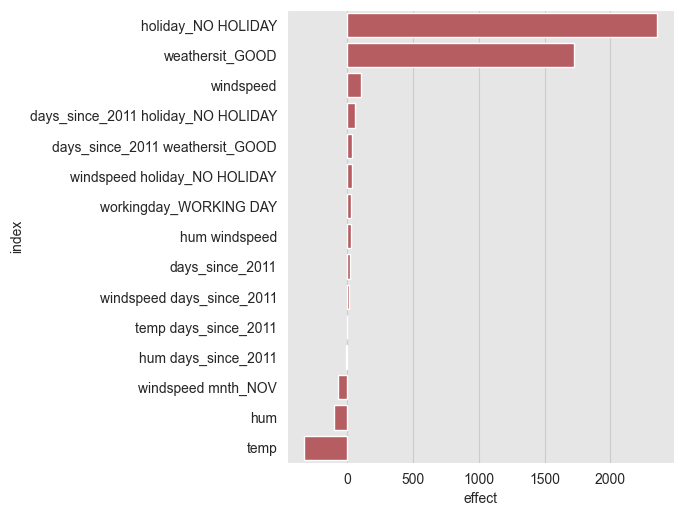

In [21]:
obs_index = 305

fig, ax = plt.subplots(figsize=(5, 6))

linear_model_effects_df.iloc[obs_index, ] \
    .to_frame() \
    .rename(columns={obs_index: 'effect'}) \
    .query('effect != 0') \
    .reset_index(drop=False) \
    .sort_values('effect', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='effect',
        y='index',
        color=sns_c[3],
        ax=ax
    )

In [22]:
linear_model_effects_df.iloc[obs_index, ].sum()

3866.919975453069

In [23]:
linear_grid_search.predict(x_train.iloc[obs_index, ].to_frame().T)[0]

3866.9199754530696

In [24]:
# pd.DataFrame(data={
#     'var_name':polynomial_features[: len(features_ext)],
#     'feature': features_ext 
# })

- Tree Model

In [25]:
tree_feature_importance_df = pd.DataFrame(data={
    'var_name': features_ext,
    'feature_importance_': tree_grid_search.best_estimator_['tree_regressor'].feature_importances_
})

tree_feature_importance_df \
    .sort_values('feature_importance_', ascending=False) \
    .reset_index(drop=True) \
    .head(15)

,var_name,feature_importance_
0,weathersit_RAIN/SNOW/STORM,0.212050
1,workingday_NO WORKING DAY,0.174873
2,workingday_WORKING DAY,0.160034
3,weekday_TUE,0.099769
4,hum,0.069206
5,days_since_2011,0.062739
6,mnth_DEZ,0.026736
7,weathersit_GOOD,0.020459
8,mnth_SEP,0.020157
9,mnth_MAY,0.017205


### PDP & ICE

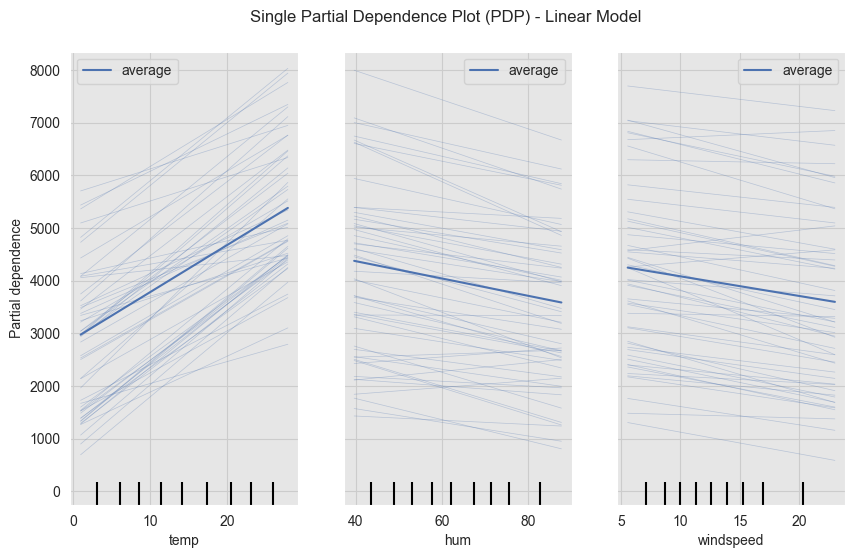

In [26]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

features_to_display = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots()

display_linear = plot_partial_dependence(
       estimator=linear_grid_search,
       X=x_train,
       features=features_to_display ,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       ax=ax
)

fig.suptitle(
       'Single Partial Dependence Plot (PDP) - Linear Model', y=0.95
);

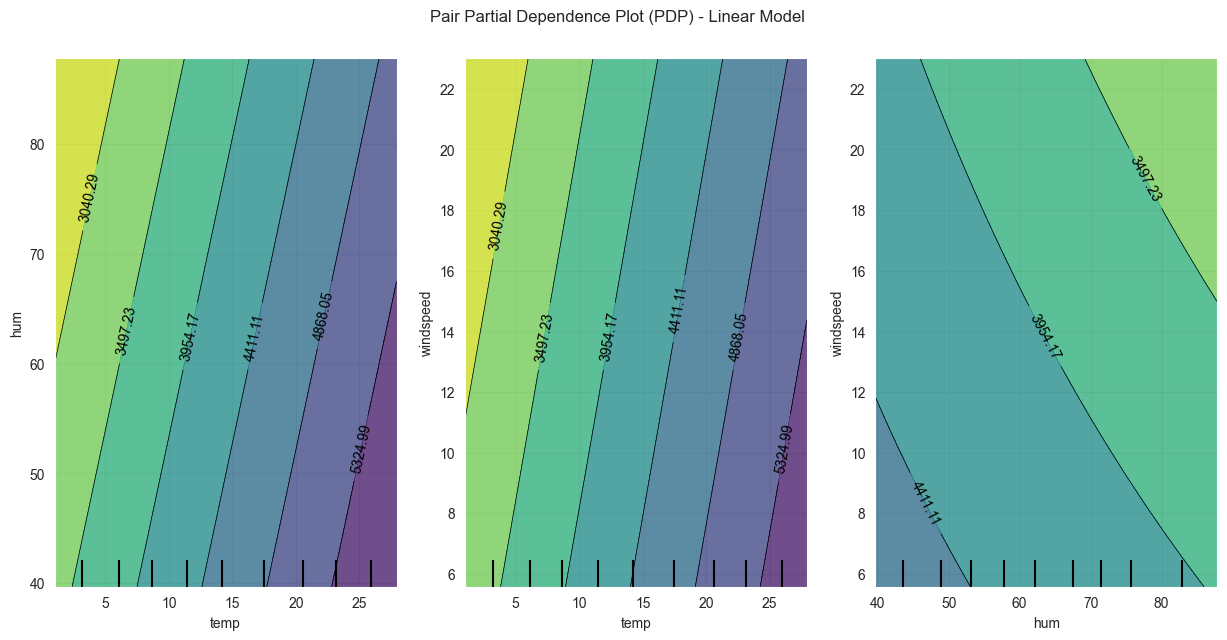

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))

features_to_display = [
    ('temp', 'hum'),
    ('temp', 'windspeed'),
    ('hum', 'windspeed')
]

display_linear = plot_partial_dependence(
       estimator=linear_grid_search,
       X=x_train,
       features=features_to_display,
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       contour_kw={'cmap': 'viridis_r'},
       ax=ax
)

fig.suptitle(
       'Pair Partial Dependence Plot (PDP) - Linear Model', y=0.95
);

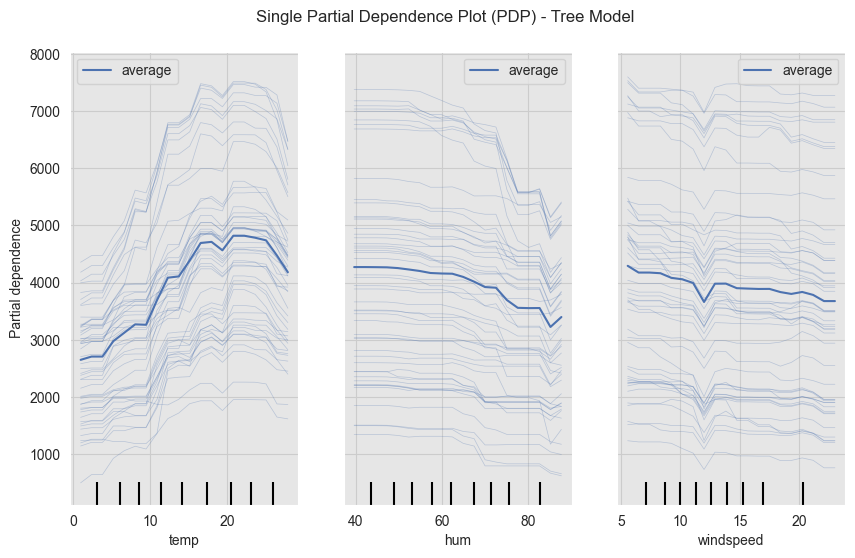

In [28]:
features_to_display = ['temp', 'hum', 'windspeed']

fig, ax = plt.subplots()

display_tree = plot_partial_dependence(
       estimator=tree_grid_search,
       X=x_train,
       features=features_to_display,
       kind='both',
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42,
       ax=ax
)

fig.suptitle(
       'Single Partial Dependence Plot (PDP) - Tree Model', y=0.95
);

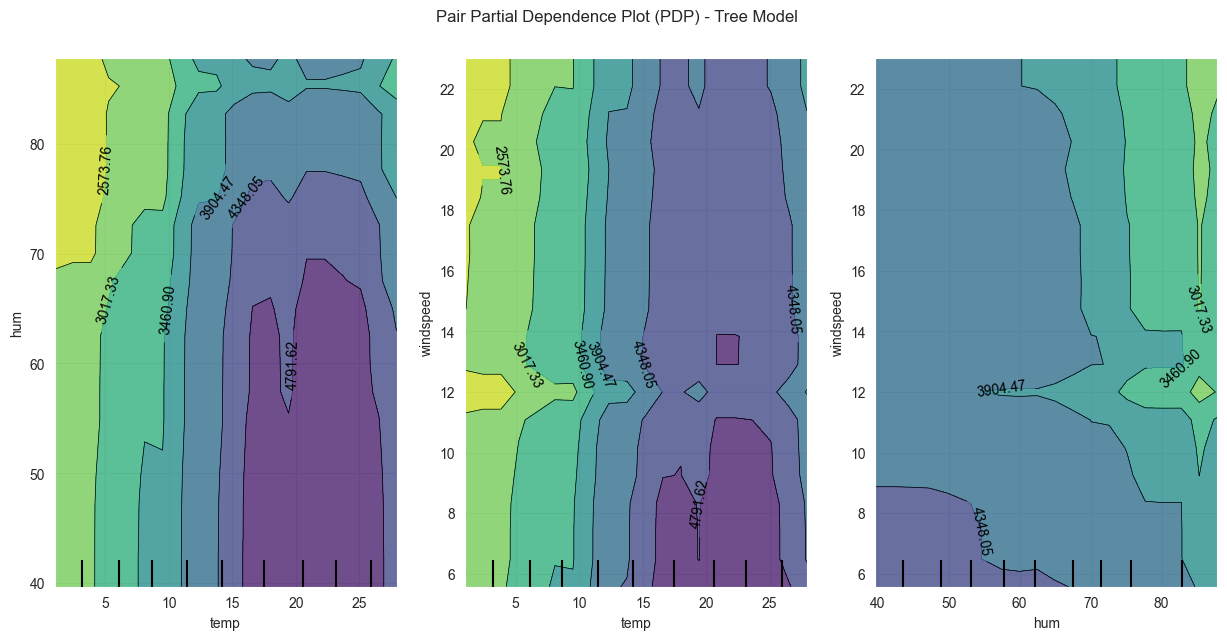

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))

features_to_display = [
    ('temp', 'hum'),
    ('temp', 'windspeed'),
    ('hum', 'windspeed')
]

display_linear = plot_partial_dependence(
       estimator=tree_grid_search,
       X=x_train,
       features=features_to_display,
       subsample=50,
       n_jobs=3, 
       grid_resolution=20,
       random_state=42, 
       contour_kw={'cmap': 'viridis_r'},
       ax=ax
)

fig.suptitle(
       'Pair Partial Dependence Plot (PDP) - Tree Model', y=0.95
);

### Permutation Importance

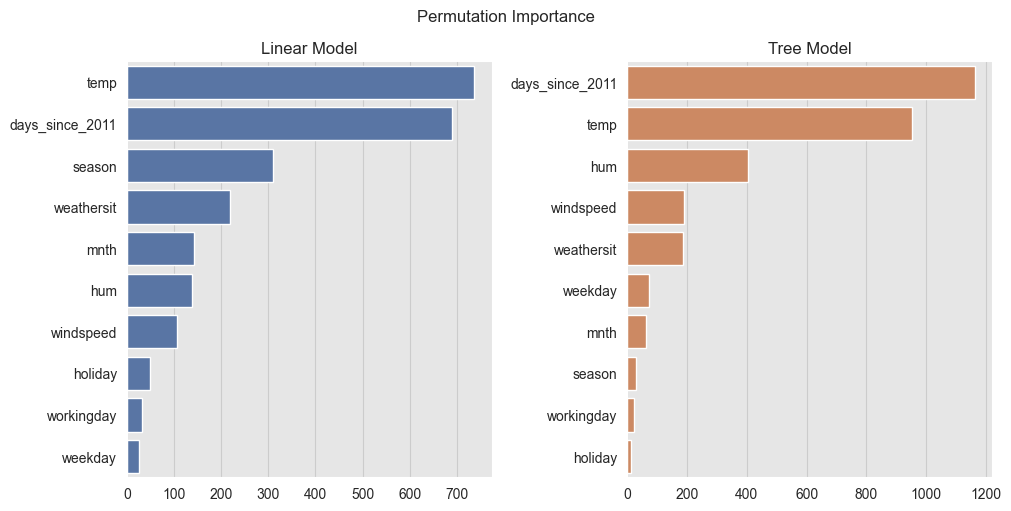

In [30]:
from sklearn.inspection import permutation_importance

linear_pi = permutation_importance(
    estimator=linear_grid_search,
    X=x_train,
    y=y_train,
    n_repeats=10
)

tree_pi = permutation_importance(
    estimator=tree_grid_search,
    X=x_train,
    y=y_train,
    n_repeats=10
)

linear_perm_sorted_idx = linear_pi.importances_mean.argsort()[::-1]
tree_perm_sorted_idx = tree_pi.importances_mean.argsort()[::-1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), constrained_layout=True)

sns.barplot(
    x=linear_pi.importances_mean[linear_perm_sorted_idx],
    y=x_train.columns[linear_perm_sorted_idx],
    orient='h',
    color=sns_c[0],
    ax=ax[0]
)
ax[0].set(title='Linear Model');

sns.barplot(
    x=tree_pi.importances_mean[tree_perm_sorted_idx],
    y=x_train.columns[tree_perm_sorted_idx],
    orient='h',
    color=sns_c[1],
    ax=ax[1]
)
ax[1].set(title='Tree Model')

fig.suptitle('Permutation Importance');